<a href="https://colab.research.google.com/github/rameshaditya-me/reinforcement-learning-from-scratch/blob/main/lecture1_MAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning From Scratch

This tutorial aims to provide a practical, code-first introduction to Reinforcement Learning (RL). Finding clear, accessible, and free learning resources, especially those focusing on implementation, can sometimes be challenging. This guide attempts to fill that gap by walking through fundamental RL concepts and implementing them step-by-step.

## Learning Approach: Code First

We will explore specific RL problems and demonstrate how various techniques can be applied to solve them. Key concepts will be explained along the way, aiming for clarity even for beginners.

This tutorial is inspired by Andrej Karpathy's excellent [Neural Networks: Zero to Hero](https://www.youtube.com/playlist?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ) series, which emphasizes understanding through implementation rather than heavy mathematical notation. We will follow a similar philosophy, building RL algorithms from the ground up using code.

## Prerequisites

To follow along effectively, you should have:

*   A good understanding of **Python**.
*   Familiarity with **PyTorch**, including basic concepts like tensors, neural network modules (`nn.Module`), optimizers, and training loops. We will be building and training neural networks later on.

If you're new to PyTorch, the first two videos of Andrej Karpathy's series provide a comprehensive introduction (approximately 4 hours total watching time).

## Tools and Environment

We will use **Google Colaboratory (Colab)** for all coding examples. Colab provides a free, browser-based Python environment with GPU access and requires no local setup, making it easy to follow along.

## Focus and Scope

A quick note on scope: While we will implement algorithms in detail, the primary focus is on understanding the core **concepts and high-level mechanics** of Reinforcement Learning. We won't delve into every minor implementation detail (like optimizing tensor shapes or exhaustive function breakdowns). The goal is to grasp the 'why' and 'how' of RL algorithms, assuming prerequisite knowledge handles lower-level coding aspects.


---

## What is Reinforcement Learning (RL)?

Before diving into code, let's establish a foundational understanding of Reinforcement Learning (RL).

At its core, RL is a type of machine learning focused on **learning through interaction**. It mirrors how humans and animals often learn: through trial and error. An entity tries an action, observes the outcome, and adjusts its future behavior based on whether the outcome was favorable or not.

<br><br>
![Reinforcement Learning Image](https://miro.medium.com/v2/resize:fit:540/1*6K-oWzwlJ4NWORSLT3Oviw.png)

*Image credit: [Medium - Vishnu Vijayan](https://medium.com/@vishnuvijayanpv/what-is-reinforcement-learning-e5dc827c8564)*
<br><br>

### Key Components

In the standard RL framework, we typically identify two primary components:

*   **The Agent:** This is the learner and decision-maker. It's the algorithm or model we are training (e.g., a game-playing AI, a robot controller). The Agent perceives its surroundings and chooses actions.
*   **The Environment:** This is the external world with which the Agent interacts. It encompasses everything outside the Agent (e.g., the game board and rules, the physical world for a robot). The Environment receives the Agent's actions and responds with new situations and feedback.

### The Agent-Environment Interaction Loop

The interaction between the Agent and the Environment follows a continuous cycle:

1.  **Observation (State):** The Agent observes the current situation of the Environment. This situation is called the **State**.
2.  **Action Selection:** Based on the observed State, the Agent chooses an **Action**.
3.  **Environment Response:** The Environment receives the Action and transitions to a new **State**.
4.  **Feedback (Reward):** The Environment also provides feedback to the Agent in the form of a scalar **Reward** signal. This reward indicates how good or bad the Agent's last action was in the context of the previous state.

This cycle repeats, generating a sequence of states, actions, and rewards.

### The Goal: Maximizing Reward

Through repeated interactions, the Agent's objective is to learn an optimal strategy, known as a **Policy**. A policy defines how the Agent chooses actions based on the current state.

The ultimate goal is to find a policy that maximizes the **cumulative reward** collected over the long run, not just the immediate reward from the next step. The Agent learns to make decisions that lead to the highest possible total score over an entire sequence of interactions (an episode or lifetime).

This fundamental loop of observation, action, and feedback forms the basis of most RL algorithms. We will soon translate these concepts into code, starting with a simple but illustrative problem.



---

## Problem 1: The Multi-Armed Bandit (MAB)

With the basic concepts of Agent, Environment, State, Action, and Reward in mind, let's tackle our first problem: the **Multi-Armed Bandit (MAB)**. This is one of the simplest settings in RL, but it's fundamental for understanding a key challenge: the exploration-exploitation trade-off.

<br><br>
![Image](https://i.sstatic.net/04Ggq.jpg)
*Image credit: [Stats Stack Exchange - Multi-Armed Bandit Problem](https://stats.stackexchange.com/questions/326449/multi-armed-bandit-problem)*
<br><br>


Imagine walking into a casino and facing a row of slot machines (or "one-armed bandits"). Each machine has a lever (an "arm") you can pull. The critical detail is that each machine is programmed differently: pulling the arm of machine *i* yields a reward drawn from a specific, hidden probability distribution unique to that machine.

For instance:
*   Machine 1 might give rewards centered around $7 (e.g., $6.50, $7.20, $6.80).
*   Machine 5 might give rewards centered around $10.

The key is that the rewards are **stochastic** (random); you don't get the exact same amount every time, just values fluctuating around the machine's true hidden average.

Your goal is to maximize your winnings over a limited number of pulls.

### The Naive Approach vs. RL

You could try a brute-force method: pull each arm 100 times, record all rewards, calculate the average for each, and then stick to the best one. This would eventually work, but it's highly inefficient, wasting many pulls on suboptimal machines.

This is where RL provides a smarter approach. We want an agent that learns adaptively, figuring out which arms are best *while* minimizing pulls on bad ones.

### Setting up the Environment: The `Bandit` Class

First, we need to simulate this row of slot machines. Let's create a Python class to represent our MAB environment. We'll start by importing the necessary libraries and define the 'Bandit' class.

In [93]:
import numpy as np
import matplotlib.pyplot as plt

class Bandit:
    """
    Represents a Multi-Armed Bandit environment.

    Args:
        true_means (list or np.array): A list containing the true mean reward
                                       for each arm.
    """
    def __init__(self, true_means):
        self.true_means = np.array(true_means)
        self.k = len(self.true_means) # Number of arms

        # Assume standard deviation of 1 for rewards from all arms
        self.std = np.ones(self.k)

        # Agent's estimates of the reward for each arm (initialized to 0)
        self.r_est = np.zeros(self.k)
        # Number of times each arm has been pulled (initialized to 0)
        self.n = np.zeros(self.k)

    def pull(self, action):
        """
        Simulates pulling an arm and returns a stochastic reward.

        Args:
            action (int): The index of the arm to pull (0 to k-1).

        Returns:
            float: A reward sampled from a Normal distribution centered
                   around the true mean for the chosen arm.
        """
        # Sample reward from Normal(mean=true_mean[action], std=1)
        reward = np.random.normal(self.true_means[action], self.std[action])
        return reward

    def update(self, action, reward):
        """
        Updates the agent's estimate for the pulled arm based on the reward received.

        Args:
            action (int): The index of the arm that was pulled.
            reward (float): The reward received from pulling the arm.
        """
        # Increment the pull count for the action
        self.n[action] += 1

        # Update the reward estimate using the incremental average formula:
        # new_estimate = old_estimate + step_size * (target - old_estimate)
        # Here, target = reward, step_size = 1/n[action]
        # self.r_est[action] = self.r_est[action] + (1 / self.n[action]) * (reward - self.r_est[action])

        # Simplified equivalent using +=
        self.r_est[action] += (reward - self.r_est[action]) / self.n[action]

#### Understanding the `Bandit` Class:

1.  **`__init__(self, true_means)`**:
    *   The constructor takes `true_means`, a list representing the hidden average payout of each arm. This is the "ground truth" the agent needs to discover.
    *   It stores these means and determines `k`, the number of arms.
    *   For simplicity, we assume the reward distribution for each arm is a Normal distribution with a standard deviation (`std`) of 1.
    *   Crucially, it initializes `r_est` (the agent's current *estimate* of each arm's reward) and `n` (the number of times each arm has been pulled) to zeros.
    *   **Note:** Technically, `r_est` and `n` represent the *agent's* knowledge. In a more complex setup, they might reside in a separate `Agent` class. For this simple MAB problem, we store them within the `Bandit` environment class for convenience.

2.  **`pull(self, action)`**:
    *   This method simulates pulling the specified `action` (arm index).
    *   It uses `np.random.normal` to draw a reward from a Normal distribution defined by the arm's `true_means` and `std`. This ensures the reward is stochastic.

3.  **`update(self, action, reward)`**:
    *   This method is called *after* the agent pulls an arm (`action`) and receives a `reward`.
    *   It first increments the count `n` for the arm that was just pulled.
    *   Then, it updates the reward estimate `r_est` for that arm using a common formula for calculating an incremental mean:
        *   `error = reward - self.r_est[action]` (How far off was our current estimate from the actual reward?)
        *   `step_size = 1 / self.n[action]` (How much weight do we give this new reward? Less weight as we get more samples.)
        *   `self.r_est[action] += step_size * error` (Nudge the old estimate towards the new reward, scaled by the step size.)
    *   This formula efficiently updates the average reward estimate without needing to store all past rewards. As `n` increases, the estimate becomes more stable.

You want something that renders cleanly in a Markdown text cell in Colab (which uses standard Markdown + inline LaTeX). So we keep math inline using `$...$` and compress the exposition into a single narrative.

### Incremental Action–Value Estimate (Multi-Armed Bandit)
In a $k$-armed bandit, suppose arm $a$ has been pulled $n$ times and produced rewards $r_1, r_2, \dots, r_n$. Instead of storing all past rewards, we update the estimate of the action value using the incremental rule
$$\hat r_a^{(n)} = \hat r_a^{(n-1)} + \frac{1}{n},(r_n - \hat r_a^{(n-1)})$$

At the first pull, $\hat r_a^{(1)} = \hat r_a^{(0)} + (r_1 - \hat r_a^{(0)}) = r_1$.

At the second pull, substituting $\hat r_a^{(1)} = r_1$ gives
$\hat r_a^{(2)} = r_1 + \frac{1}{2}(r_2 - r_1) = \frac{r_1 + r_2}{2}$.

At the third pull,
$\hat r_a^{(3)} = \frac{r_1+r_2}{2} + \frac{1}{3}!\left(r_3 - \frac{r_1+r_2}{2}\right) = \frac{r_1+r_2+r_3}{3}$.

Continuing this pattern and proving by induction yields the general result
$\hat r_a^{(n)} = \frac{1}{n}\sum_{i=1}^{n} r_i$, meaning the incremental update is exactly the running sample mean of the observed rewards.

If the rewards are i.i.d. with expectation $\mathbb{E}[r_i]=\mu_a$, then by the Strong Law of Large Numbers the sample mean converges almost surely: $\hat r_a^{(n)} \to \mu_a$ as $n\to\infty$. Therefore the bandit update $\hat r_a \leftarrow \hat r_a + \frac{1}{N_a}(r-\hat r_a)$ is simply an online (streaming) estimator of the true action value $Q(a)=\mathbb{E}[r|a]$, and repeated sampling of the arm drives the estimate toward the true expected reward.



### The Agent's Strategy: Exploration vs. Exploitation

Okay, we have our `Bandit` environment set up. It knows the true means (secretly), gives stochastic rewards, and helps track estimates. But the environment itself doesn't make decisions. We need an **agent strategy** (or policy) to decide which arm to pull at each step.

This immediately brings us to the **exploration-exploitation dilemma**:

*   **Explore:** Should the agent try out different arms, even those that currently seem mediocre based on `r_est`? It might get a low reward *now*, but it could discover a truly great arm that was initially underestimated.
*   **Exploit:** Should the agent just pull the arm that currently has the highest `r_est`? This maximizes the expected immediate reward based on current knowledge, but it risks missing out on the *actual* best arm if the initial estimates were wrong due to insufficient exploration.

A good strategy needs to balance these two. Explore enough to gather good information, but exploit that information effectively to maximize rewards.

### Epsilon-Greedy Strategy

One of the simplest and most popular strategies to balance this trade-off is **epsilon-greedy**.

The core idea is:
*   Most of the time (with probability 1 - ε), **exploit** by choosing the arm with the highest current estimated reward (`r_est`).
*   Some of the time (with probability ε), **explore** by choosing an arm completely at random.

Let's implement this strategy as a Python function.

In [94]:
def epsilon_greedy(bandit_instance, episodes=1000, epsilon=0.1):
    """
    Implements the epsilon-greedy strategy for a Multi-Armed Bandit problem.

    Args:
        bandit_instance (Bandit): An instance of the Bandit class.
        episodes (int): The total number of pulls (time steps) to run.
        epsilon (float): The probability of choosing an action randomly (exploration rate).

    Returns:
        tuple: A tuple containing:
            - np.array: The final estimated rewards for each arm (r_est).
            - np.array: A history of the reward received at each episode.
    """
    # Array to store the reward received at each episode
    rewards = np.zeros(episodes)

    # Main loop: iterate for the specified number of episodes
    for i in range(episodes):
        # Decide whether to explore or exploit
        if np.random.rand() < epsilon:
            # Explore: choose a random arm
            action = np.random.randint(0, bandit_instance.k)
        else:
            # Exploit: choose the arm with the highest current estimated reward
            action = np.argmax(bandit_instance.r_est)

        # Pull the chosen arm and get the reward
        reward = bandit_instance.pull(action)

        # Update the bandit's estimates based on the action and reward
        bandit_instance.update(action, reward)

        # Store the reward for this episode
        rewards[i] = reward

    # Return the final estimates and the history of rewards
    return bandit_instance.r_est, rewards

#### Understanding the `epsilon_greedy` Function:

1.  **Inputs:**
    *   `bandit_instance`: The `Bandit` environment we created.
    *   `episodes`: How many times the agent will pull an arm in total.
    *   `epsilon` (ε): The exploration probability (e.g., 0.1 means 10% chance of exploring).
2.  **Initialization:**
    *   Creates a `rewards` array to log the reward obtained at each step.
3.  **Main Loop (`for i in range(episodes):`)**:
    *   **Action Selection:**
        *   Generates a random float between 0 and 1 (`np.random.rand()`).
        *   If this float is less than `epsilon`, the agent **explores**: it picks a random arm index using `np.random.randint`.
        *   Otherwise (with probability 1-`epsilon`), the agent **exploits**: it uses `np.argmax(bandit_instance.r_est)` to find the index of the arm with the currently highest estimated reward.
    *   **Interaction:**
        *   Calls `bandit_instance.pull(action)` to get a `reward` from the environment based on the chosen `action`.
        *   Calls `bandit_instance.update(action, reward)` to update the estimates (`n` and `r_est`) for the chosen arm within the environment object.
    *   **Logging:** Stores the received `reward` in the `rewards` array.
4.  **Outputs:**
    *   Returns the final `bandit_instance.r_est` (the agent's learned estimates after all episodes).
    *   Returns the `rewards` array (the history of rewards obtained step-by-step).

This function encapsulates the entire agent's learning process using the epsilon-greedy strategy.

---

Now we have the `Bandit` environment and the `epsilon_greedy` learning algorithm. We're ready to set up an experiment, run the simulation, and see how well our agent learns!

### Running the Epsilon-Greedy Experiment

Let's put our `Bandit` environment and `epsilon_greedy` strategy into action.

First, since we use random numbers (for action selection in epsilon-greedy and for reward generation in `Bandit.pull`), it's good practice to set a random seed. This ensures that if we run the code again, we get the exact same sequence of "random" events, making our experiment reproducible. Next, define the parameters for our experiment: the total number of pulls (`episodes`) and the true underlying quality of each arm (`true_means`).

Then, we create an instance of our `Bandit` environment using these `true_means` and run the `epsilon_greedy` function.

In [95]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of episodes (pulls)
episodes = 1000

# Define the true mean reward for each of the 10 arms.
# These are the 'secrets' the agent needs to discover.
true_means = [0.1, -0.5, 1.5, 0.8, 1.1, -1.0, 0.3, 0.6, 1.7, 1.4]
# The best arm is index 8 with a true mean of 1.7
print(f"Number of arms: {len(true_means)}")
print(f"Maximum true mean reward: {max(true_means)}")

# Create a Bandit instance for the epsilon-greedy agent
bandit_eps = Bandit(true_means)

# Run the epsilon-greedy strategy
# Keep the default epsilon of 0.1 (10% exploration)
eps_final_r_est, rewards_eps = epsilon_greedy(bandit_eps, episodes, epsilon=0.1)

print(f"Ran {episodes} episodes for epsilon-greedy.")
# rewards_eps now holds the reward obtained at each of the 1000 steps.
# eps_final_r_est holds the agent's final estimate of each arm's value.

Number of arms: 10
Maximum true mean reward: 1.7
Ran 1000 episodes for epsilon-greedy.


#### Visualizing Performance: Cumulative Average Reward

Simply looking at the `rewards_eps` array (1000 individual rewards) isn't very informative about learning progress due to the inherent randomness. A better way to visualize learning is to plot the **cumulative average reward** over time. This shows the average reward obtained *up to* each step.

We calculate this as follows:

In [96]:
# Calculate cumulative average reward for epsilon-greedy
# np.cumsum(rewards_eps) calculates the cumulative sum at each step
# np.arange(episodes) + 1 creates an array [1, 2, ..., episodes]
avg_eps = np.cumsum(rewards_eps) / (np.arange(episodes) + 1)

Now, let's plot this average reward curve. We'll also add a line indicating the best possible average reward (the true mean of the best arm).

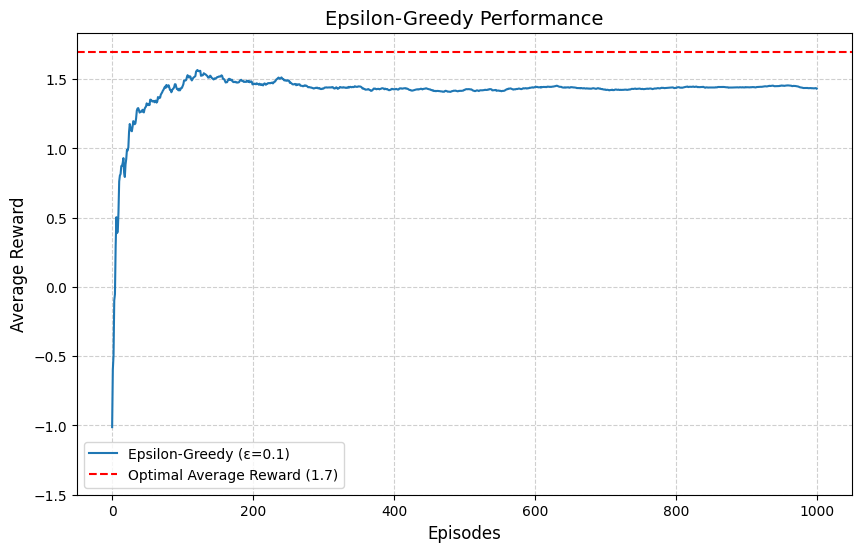

In [97]:
# --- Plotting Epsilon-Greedy Performance ---
plt.figure(figsize=(10, 6))

plt.plot(avg_eps, label='Epsilon-Greedy (ε=0.1)')

# A line for the best possible average reward
plt.axhline(y=max(true_means), color='red', linestyle='--', label=f'Optimal Average Reward ({max(true_means)})')

plt.xlabel('Episodes', fontsize=12)
plt.ylabel('Average Reward', fontsize=12)
plt.title('Epsilon-Greedy Performance', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(bottom=min(true_means)-0.5)
plt.show()

#### Analyzing Epsilon-Greedy's Result

Looking at the plot, we observe:

*   **Learning Curve:** The average reward clearly increases over time, indicating that the agent *is* learning to prefer better arms.
*   **Plateau Below Optimal:** The curve seems to level off (plateau) noticeably below the red dashed line representing the maximum possible average reward (1.7).

Why doesn't it reach the optimal value? This illustrates the limitation of standard epsilon-greedy:

*   **Constant Exploration:** The agent explores randomly `epsilon` (10%) of the time, *always*. Even after it has learned which arm is best (arm 8), it continues to waste 10% of its pulls on other, potentially much worse, arms.
*   **Diminishing Returns:** While constant exploration prevents getting stuck permanently on a suboptimal arm, it prevents the agent from fully exploiting the best arm once found. The average reward is constantly dragged down by these forced random pulls.

#### Checking Learned Estimates

Let's also see how well the agent learned the actual values of the arms after 1000 episodes:

In [98]:
print("True means:")
print(true_means)
print("\nEpsilon-Greedy Final Estimates (rounded):")
print(np.round(eps_final_r_est, 2))

# Optional: Run for more episodes to see convergence
# bandit_eps_long = Bandit(true_means)
# eps_final_r_est_long, _ = epsilon_greedy(bandit_eps_long, 4000, epsilon=0.1)
# print("\nEpsilon-Greedy Estimates after 4000 episodes (rounded):")
# print(np.round(eps_final_r_est_long, 2))

True means:
[0.1, -0.5, 1.5, 0.8, 1.1, -1.0, 0.3, 0.6, 1.7, 1.4]

Epsilon-Greedy Final Estimates (rounded):
[-0.17 -0.37  1.55  0.74  1.07 -0.9   1.25  0.74  1.12  1.2 ]


The estimates are reasonably close to the true means, especially for arms pulled more often. Given enough pulls (e.g., 4000 episodes, as shown in the commented-out code), epsilon-greedy *will* eventually converge to the true values. However, its *performance* (average reward) remains capped below optimal due to the persistent exploration.

So, while simple and effective to a degree, epsilon-greedy's performance limitation motivates exploring alternative strategies that handle the exploration-exploitation balance more intelligently.

---
**Part 3: $\epsilon$ greedy with decaying $ϵ$**

Instead of keeping the epsilon value constant across the episodes, a better way is to slowly decay the $\epsilon$ value as the episodes progress and the bandit gets more confident about the reward estimates. This can be done by using a scheduler for epsilon value. We will explore 6 schedulers 1. Linear 2. Exponential 3. Inverse 4. Cyclical 5. Cosine and 6. Constant. First, let's visualize these schedulers.

 Let's Implement this strategy as a Python function

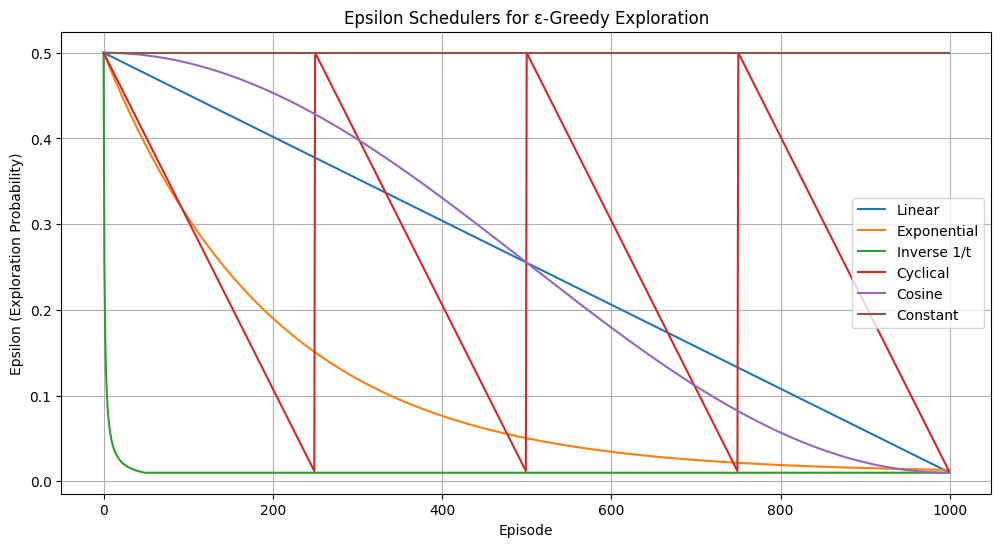

In [99]:
import matplotlib.pyplot as plt
import math

def visualize_scheduler(index: int, epsilon_initial=0.5, epsilon_final=0.01, episodes=1000, scheduler_type=None) -> float:
      if scheduler_type == "linear":
        # linear scheduler
        return epsilon_initial+index/episodes*(epsilon_final-epsilon_initial)
      elif scheduler_type == "exp":
        # exponential scheduler
        decay_rate = 5 / episodes   # controls speed
        return epsilon_final + (epsilon_initial - epsilon_final) * math.exp(-decay_rate * index)
      elif scheduler_type == "inverse":
        # inverse scheduler
        return max(epsilon_final, epsilon_initial/(index+1))
      elif scheduler_type == "cyclical":
        # cyclical scheduler
        cycle = episodes // 4
        phase = index % cycle
        return epsilon_final + (epsilon_initial-epsilon_final)*(1 - phase/cycle)
      elif scheduler_type == "cosine":
        # cosine scheduler
        return epsilon_final + 0.5*(epsilon_initial-epsilon_final)*(1+math.cos(math.pi*index/episodes))
      else:
        # assume constant scheduler
        return epsilon_initial

linear = []
exponential = []
inverse = []
cyclical = []
cosine = []
constant = []
episodes = 1000
epsilon_initial=0.5
epsilon_final=0.01
for i in range(1000):
  linear.append(visualize_scheduler(index=i, epsilon_initial=epsilon_initial, epsilon_final=epsilon_final, episodes=episodes,scheduler_type="linear"))
  exponential.append(visualize_scheduler(index=i, epsilon_initial=epsilon_initial, epsilon_final=epsilon_final, episodes=episodes,scheduler_type="exp"))
  inverse.append(visualize_scheduler(index=i, epsilon_initial=epsilon_initial, epsilon_final=epsilon_final, episodes=episodes,scheduler_type="inverse"))
  cyclical.append(visualize_scheduler(index=i, epsilon_initial=epsilon_initial, epsilon_final=epsilon_final, episodes=episodes,scheduler_type="cyclical"))
  cosine.append(visualize_scheduler(index=i, epsilon_initial=epsilon_initial, epsilon_final=epsilon_final, episodes=episodes,scheduler_type="cosine"))
  constant.append(visualize_scheduler(index=i, epsilon_initial=epsilon_initial, epsilon_final=epsilon_final, episodes=episodes,scheduler_type="constant"))

x = list(range(episodes))

plt.figure(figsize=(12,6))

plt.plot(x, linear, label="Linear")
plt.plot(x, exponential, label="Exponential")
plt.plot(x, inverse, label="Inverse 1/t")
plt.plot(x, cyclical, label="Cyclical")
plt.plot(x, cosine, label="Cosine")
plt.plot(x, constant, label="Constant")

plt.xlabel("Episode")
plt.ylabel("Epsilon (Exploration Probability)")
plt.title("Epsilon Schedulers for ε-Greedy Exploration")
plt.legend()
plt.grid(True)

plt.show()

As you can see, different schedulers decay epsilon in different ways.
1. A linear scheduler decreases the exploration probability at a constant rate, moving $\epsilon$ steadily from $\epsilon_{initial}$ to $\epsilon_{final}$ over the course of training.

2. An exponential scheduler reduces $\epsilon$ more aggressively early on than linear decay, so exploration drops rapidly at the beginning and the agent begins exploiting much sooner.

3. An inverse schedule (typically $\epsilon_t \propto 1/t$ or $1/\sqrt{t}$) drops exploration very quickly in the beginning but then decays extremely slowly. This guarantees that every arm continues to be sampled infinitely often, which is why it appears in convergence proofs for stochastic bandits.

4. A cosine scheduler reduces $\epsilon$ smoothly: exploration decreases slowly at first, faster in the middle of training, and then levels off near $\epsilon_{final}$. Because the tail is gentle, the agent keeps occasional exploration late in learning, helping it refine value estimates.

5. A cyclical scheduler periodically increases $\epsilon$ again after it has decayed. These repeated bursts of exploration allow the agent to escape local optima and are particularly useful in sparse-reward or long-horizon environments where a policy can prematurely commit to a suboptimal behavior.

6. A constant scheduler keeps $\epsilon$ fixed throughout training. While it never fully exploits, it is important for non-stationary bandits and changing environments, since continuous exploration allows the agent to detect when the optimal action has shifted.

Now let us compare the performance of the vanilla epsilon-greedy-bandit with the epsilon-greedy-bandit with scheduling.


In [100]:
def epsilon_greedy_with_decaying_epsilon(bandit_instance, episodes=1000, epsilon_initial=0.1, epsilon_final=0.05, scheduler_type=None):
    """
    Implements the epsilon-greedy strategy for a Multi-Armed Bandit problem.

    Args:
        bandit_instance (Bandit): An instance of the Bandit class.
        episodes (int): The total number of pulls (time steps) to run.
        epsilon (float): The probability of choosing an action randomly (exploration rate).

    Returns:
        tuple: A tuple containing:
            - np.array: The final estimated rewards for each arm (r_est).
            - np.array: A history of the reward received at each episode.
    """
    def scheduler(index: int) -> float:
      if scheduler_type == "linear":
        # linear scheduler
        return epsilon_initial-index/episodes*(epsilon_final-epsilon_initial)
      elif scheduler_type == "exp":
        # exponential scheduler
        decay_rate = 50 / episodes   # controls speed
        return epsilon_final + (epsilon_initial - epsilon_final) * math.exp(-decay_rate * index)
      elif scheduler_type == "inverse":
        # inverse scheduler
        return max(epsilon_final, epsilon_initial/(index+1))
      elif scheduler_type == "cyclical":
        # cyclical scheduler
        cycle = episodes // 4
        phase = index % cycle
        return epsilon_final + (epsilon_initial-epsilon_final)*(1 - phase/cycle)
      elif scheduler_type == "cosine":
        # cosine scheduler
        return epsilon_final + 0.5*(epsilon_initial-epsilon_final)*(1+math.cos(math.pi*index/episodes))
      else:
        # assume constant scheduler
        return epsilon_initial

    # Array to store the reward received at each episode
    rewards = np.zeros(episodes)
    regret = np.zeros(episodes)

    # Main loop: iterate for the specified number of episodes
    for i in range(episodes):
        epsilon = scheduler(i)
        # Decide whether to explore or exploit
        if np.random.rand() < epsilon:
            # Explore: choose a random arm
            action = np.random.randint(0, bandit_instance.k)
        else:
            # Exploit: choose the arm with the highest current estimated reward
            action = np.argmax(bandit_instance.r_est)

        # store the regret
        regret[i] = np.max(true_means)-bandit_instance.r_est[action]
        # Pull the chosen arm and get the reward
        reward = bandit_instance.pull(action)

        # Update the bandit's estimates based on the action and reward
        bandit_instance.update(action, reward)

        # Store the reward for this episode
        rewards[i] = reward

    # Return the final estimates and the history of rewards
    return bandit_instance.r_est, rewards, r_est_t

Number of arms: 10
Maximum true mean reward: 1.7
Ran 1000 episodes for epsilon-greedy with schedule linear.
Number of arms: 10
Maximum true mean reward: 1.7
Ran 1000 episodes for epsilon-greedy with schedule exponential.
Number of arms: 10
Maximum true mean reward: 1.7
Ran 1000 episodes for epsilon-greedy with schedule inverse.
Number of arms: 10
Maximum true mean reward: 1.7
Ran 1000 episodes for epsilon-greedy with schedule cosine.
Number of arms: 10
Maximum true mean reward: 1.7
Ran 1000 episodes for epsilon-greedy with schedule cyclical.
Number of arms: 10
Maximum true mean reward: 1.7
Ran 1000 episodes for epsilon-greedy with schedule constant.


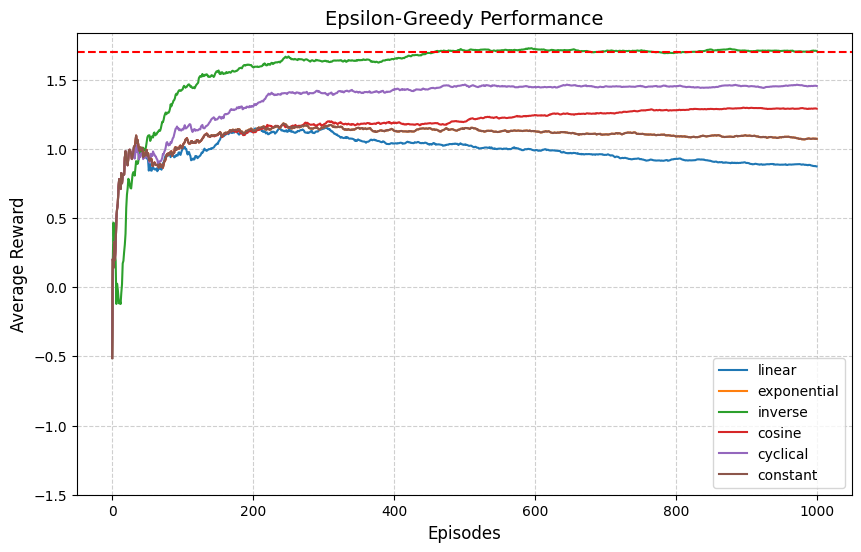

In [101]:
results = {}
# --- Plotting Epsilon-Greedy Performance ---
plt.figure(figsize=(10, 6))

for scheduler in ["linear","exponential","inverse","cosine","cyclical","constant"]:
  np.random.seed(42)

  # Number of episodes (pulls)
  episodes = 1000

  # Define the true mean reward for each of the 10 arms.
  # These are the 'secrets' the agent needs to discover.
  true_means = [0.1, -0.5, 1.5, 0.8, 1.1, -1.0, 0.3, 0.6, 1.7, 1.4]
  # The best arm is index 8 with a true mean of 1.7
  print(f"Number of arms: {len(true_means)}")
  print(f"Maximum true mean reward: {max(true_means)}")

  # Create a Bandit instance for the epsilon-greedy agent
  bandit_eps = Bandit(true_means)

  # Run the epsilon-greedy strategy
  # Keep the default epsilon of 0.1 (10% exploration)
  eps_final_r_est, rewards_eps, regret_eps = epsilon_greedy_with_decaying_epsilon(bandit_eps, episodes, epsilon_initial=0.5, epsilon_final=0.01, scheduler_type=scheduler)
  print(f"Ran {episodes} episodes for epsilon-greedy with schedule {scheduler}.")

  # Calculate cumulative average reward for epsilon-greedy
  # np.cumsum(rewards_eps) calculates the cumulative sum at each step
  # np.arange(episodes) + 1 creates an array [1, 2, ..., episodes]
  avg_eps = np.cumsum(rewards_eps) / (np.arange(episodes) + 1)
  results[scheduler] = (avg_eps, regret_eps)
  plt.plot(avg_eps, label=f'{scheduler}')


plt.xlabel('Episodes', fontsize=12)
plt.ylabel('Average Reward', fontsize=12)
plt.title('Epsilon-Greedy Performance', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(bottom=min(true_means)-0.5)
# A line for the best possible average reward
plt.axhline(y=max(true_means), color='red', linestyle='--', label=f'Optimal Average Reward ({max(true_means)})')
plt.show()


As you can see, the epsilon greedy approach with scheduling improved the performance over vanilla-epsilon greedy.
---

**Part 2: Upper Confidence Bound (UCB) and Comparison**

### A Smarter Exploration Strategy: Upper Confidence Bound (UCB)

Instead of simple random exploration, the Upper Confidence Bound (UCB) strategy takes a more optimistic approach. It tries to quantify the uncertainty about each arm's estimate and uses that uncertainty to guide exploration.

The core idea is to select the action `a` that maximizes the following value at each time step `t`:

$$ \text{UCB}(a) = \underbrace{Q_t(a)}_{\text{Current Estimate}} + \underbrace{c \sqrt{\frac{\ln t}{N_t(a)}}}_{\text{Exploration Bonus}} $$

Where:
*   $Q_t(a)$ is the current estimated reward for arm `a` (our `r_est[a]`).
*   $N_t(a)$ is the number of times arm `a` has been pulled up to time `t` (our `n[a]`).
*   $t$ is the current time step (total number of pulls so far, starting from 1).
*   $c$ is a constant (hyperparameter) controlling the level of exploration. Higher `c` means more exploration.

Let's break down the **Exploration Bonus**:
*   **$\ln t$**: The logarithm of the current time step. It grows slowly over time.
*   **$N_t(a)$**: The number of pulls for arm `a`. Grows linearly with pulls of `a`.
*   **$\sqrt{\frac{\ln t}{N_t(a)}}$**: This term is large when an arm `a` has been pulled infrequently ($N_t(a)$ is small) relative to the total time `t`. It shrinks as an arm is pulled more often. The square root helps tune the rate at which the bonus decreases.
*   **$c$**: The exploration parameter scales the bonus.

Essentially, UCB favors arms that either have a high current estimate ($Q_t(a)$) or have high uncertainty (haven't been pulled much, resulting in a large bonus). This encourages exploration of less-certain arms in a more directed way than epsilon-greedy's random selection.

Let's derive this mathematically,

Below is a compact mathematical derivation that shows where the UCB rule actually comes from.
(Important point: UCB is not a heuristic — it is derived from a **high-probability confidence interval on the true mean reward**.)

---

## Mathematical Derivation of UCB

Consider a stochastic $k$-armed bandit. Each arm $a$ produces i.i.d. rewards
$r_1, r_2, \dots, r_{N_t(a)} \sim \mathcal{D}_a$ with unknown mean
$\mu_a = \mathbb{E}[r|a]$.

We estimate the mean reward using the empirical average

$\hat{\mu}*a(t) = \frac{1}{N_t(a)} \sum*{i=1}^{N_t(a)} r_i$.

The problem is: **we do not know how accurate this estimate is**. (In other words we have not considered the variance of this estimator) UCB solves exploration by constructing a *confidence interval* around $\hat{\mu}_a(t)$.


#### Step 1 — Concentration Inequality (Hoeffding’s Inequality)

Assume rewards are bounded: $r \in [0,1]$.

Hoeffding’s inequality gives a probabilistic guarantee on the deviation between the sample mean and the true mean:

$P!\left(|\hat{\mu}_a(t) - \mu_a| \ge \epsilon \right) \le 2\exp(-2N_t(a)\epsilon^2)$

This tells us:

> the more times we pull an arm, the more tightly the estimate concentrates around the true value. This is due to the fact that the probability the absolute deviation between the true reward mean and its estimate is larger than $\epsilon$ decays exponentially with increases in number of pull of the arm $N_t(a)$.

#### Step 2 — Convert to a Confidence Bound

We want a confidence radius $\epsilon$ such that the failure probability is very small.

Set the RHS equal to $\delta$:

$2\exp(-2N_t(a)\epsilon^2) = \delta$

Solve for $\epsilon$:

$\epsilon = \sqrt{\frac{\ln(2/\delta)}{2N_t(a)}}$

So with probability at least $1-\delta$:

$\mu_a \le \hat{\mu}_a(t) + \sqrt{\frac{\ln(2/\delta)}{2N_t(a)}}$

This gives an **upper confidence bound** on the true mean reward.

#### Step 3 — Make the Bound Time-Dependent

We are making decisions at every time step $t$, so we want the confidence to hold *for all times*, not just once. Choose the failure probability to shrink with time i.e decay with time: $\delta = \frac{1}{t^2}$

(technical reason: $\sum_{t=1}^\infty 1/t^2 < \infty$, so the total probability of ever being wrong stays bounded — union bound argument).

Substituting for $\delta$ we get $\ln(2/\delta) = \ln(2t^2) \approx 2\ln t$

Ignoring constants (absorbed into a tunable parameter $c$):

confidence radius $;\approx; \sqrt{\frac{\ln t}{N_t(a)}}$

#### Step 4 — Optimism in the Face of Uncertainty

We now have, with high probability,

$\mu_a \le \hat{\mu}_a(t) + \sqrt{\frac{\ln t}{N_t(a)}}$

So the **best plausible value** of arm $a$ is:

Upper Confidence Bound:

$\text{UCB}(a) = \hat{\mu}_a(t) + c\sqrt{\frac{\ln t}{N_t(a)}}$

and the action selected is

$a_t = \arg\max_a \text{UCB}(a)$.

#### Interpretation

UCB implements a precise principle:

**Optimism under uncertainty**

An arm is chosen if:

* its empirical reward is high (exploitation), or
* its estimate is unreliable (large uncertainty bonus).

Notice the behavior:

* If $N_t(a)$ is small → large bonus → forced exploration
* If $N_t(a)$ is large → bonus shrinks → exploitation
* As $t$ grows → exploration slows logarithmically

So unlike ε-greedy, exploration is **directed**, not random.

---

#### Why the $\ln t$ Matters

The $\ln t$ term ensures:

* every arm is explored infinitely often
* but only logarithmically many times

This leads to a regret guarantee:

$\text{Regret}(T) = O!\left(\sum_{a \ne a^*} \frac{\ln T}{\Delta_a}\right)$

where $\Delta_a = \mu_{a^*} - \mu_a$ is the optimality gap.

This is exponentially better than ε-greedy, whose regret grows linearly in $T$.

---

#### Key Insight

ε-greedy asks:

> “Should I explore?”

UCB asks:

> “Which arm is most likely to be optimal given uncertainty?”

That single change — replacing random exploration with statistically justified optimism — is why UCB is the first *principled* bandit algorithm.


Let's implement this strategy.

In [102]:
def ucb_strategy(bandit_instance, episodes=1000, c=1):
    """
    Implements the Upper Confidence Bound (UCB) strategy.

    Args:
        bandit_instance (Bandit): An instance of the Bandit class.
        episodes (int): The total number of pulls (time steps) to run.
        c (float): The exploration parameter controlling confidence level.

    Returns:
        tuple: A tuple containing:
            - np.array: The final estimated rewards for each arm (r_est).
            - np.array: A history of the reward received at each episode.
    """
    rewards = np.zeros(episodes)
    k = bandit_instance.k
    regret = np.zeros(episodes)

    # --- Initial Exploration Phase ---
    # UCB requires n[action] > 0 for the formula. Pull each arm once initially.
    for arm in range(k):
        if episodes <= arm: # Handle cases where episodes < number of arms
             break
        reward = bandit_instance.pull(arm)
        bandit_instance.update(arm, reward)
        rewards[arm] = reward
        regret[arm] = np.max(true_means)-bandit_instance.r_est[arm]


    # --- Main UCB Loop ---
    # Start from the number of arms already pulled (k)
    # Use i+1 for log because time steps usually start from 1
    for i in range(k, episodes):
        # Calculate UCB values for all arms
        # Add a small epsilon (1e-6) to avoid division by zero or log(0) issues
        # We use i+1 because log(0) is undefined and time starts conceptually at t=1
        exploration_bonus = c * np.sqrt(np.log(i + 1) / (bandit_instance.n + 1e-6))
        ucb_values = bandit_instance.r_est + exploration_bonus


        # Select the arm with the highest UCB value
        action = np.argmax(ucb_values)
        r_est_t.append(bandit_instance.r_est[action])

        # Pull the chosen arm and get the reward
        reward = bandit_instance.pull(action)

        # Update the bandit's estimates
        bandit_instance.update(action, reward)

        # Store the reward
        rewards[i] = reward

    return bandit_instance.r_est, rewards, r_est_t

#### Running UCB and Comparing Strategies

Now, let's run the UCB strategy on a fresh `Bandit` instance and compare its performance to epsilon-greedy by plotting both average reward curves together.


Ran 1000 episodes for UCB (c=1).


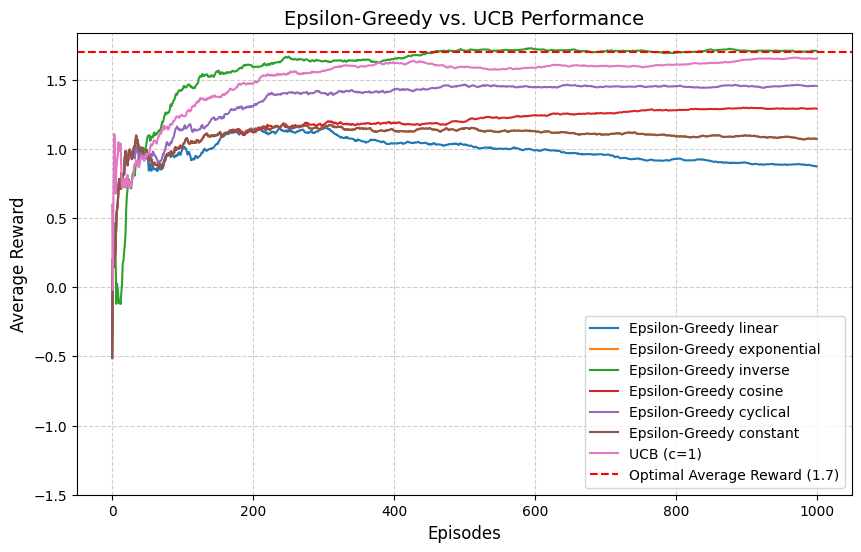

In [103]:
# Create a new Bandit instance for the UCB agent
# Important: Use a new instance so its estimates (r_est, n) start from zero
bandit_ucb = Bandit(true_means)

# Set the random seed again just before running UCB for consistency
np.random.seed(42)
episodes = 1000
# Run the UCB strategy
ucb_final_r_est, rewards_ucb, ucb_final_r_est_t = ucb_strategy(bandit_ucb, episodes, c=1)

print(f"\nRan {episodes} episodes for UCB (c=1).")

# Calculate cumulative average reward for UCB
avg_ucb = np.cumsum(rewards_ucb) / (np.arange(episodes) + 1)

# --- Plotting the Comparison ---
plt.figure(figsize=(10, 6))
for scheduler in results.keys():
  plt.plot(results[scheduler][0], label=f'Epsilon-Greedy {scheduler}')
plt.plot(avg_ucb, label='UCB (c=1)')

# Add a line for the best possible average reward
plt.axhline(y=max(true_means), color='red', linestyle='--', label=f'Optimal Average Reward ({max(true_means)})')

plt.xlabel('Episodes', fontsize=12)
plt.ylabel('Average Reward', fontsize=12)
plt.title('Epsilon-Greedy vs. UCB Performance', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(bottom=min(true_means)-0.5)
plt.show()

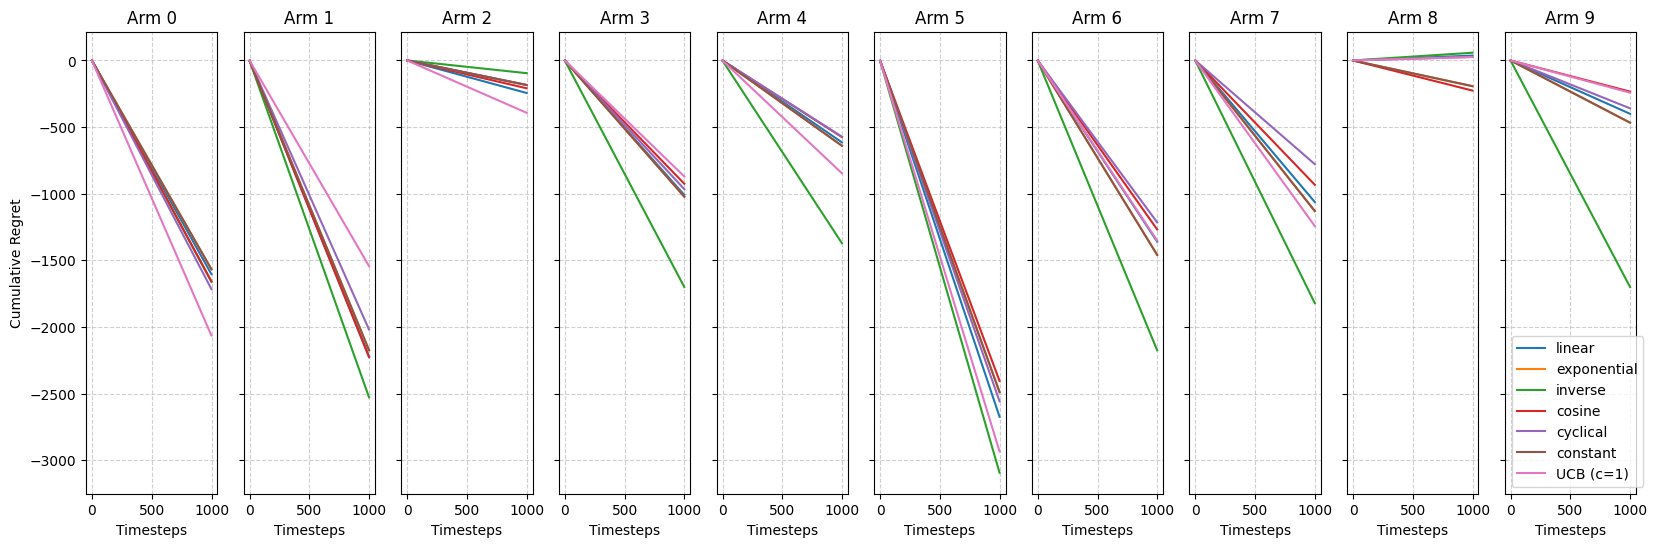

In [108]:
true_means = np.array(true_means).reshape(1,10)
fig, axes = plt.subplots(1, true_means.shape[-1], figsize=(20,6), sharey=True)
legend_handles = {}
for scheduler in results.keys():
    step_wise_regret = (results[scheduler][1] - np.max(true_means))

    for arm in range(true_means.shape[-1]):
        line, = axes[arm].plot(
            np.cumsum(step_wise_regret[:,arm]),
            label=f'{scheduler}'
        )

        # save only once
        if scheduler not in legend_handles:
            legend_handles[scheduler] = line

step_wise_regret_ucb = np.array(ucb_final_r_est_t) - np.max(true_means)

for arm in range(true_means.shape[-1]):
    line, = axes[arm].plot(
        np.cumsum(step_wise_regret_ucb[:,arm]),
        label='UCB (c=1)'
    )

    if 'UCB (c=1)' not in legend_handles:
        legend_handles['UCB (c=1)'] = line

for arm in range(true_means.shape[-1]):
    axes[arm].set_title(f'Arm {arm}')
    axes[arm].set_xlabel('Timesteps')
    axes[arm].grid(True, linestyle='--', alpha=0.6)

axes[0].set_ylabel('Cumulative Regret')
plt.legend()

#### Analyzing the Comparison

Looking at the combined plot and the final estimates:

* **Performance:** The performance comparison is as follows Inverse > UCB > Cyclical > Cosine > Constant > Linear $\approx$ Exponential
* The performance gap can be attributed to how the exploration-exploitation tradeoff is handled by each bandit. In the early stages of training, the UCB and Inverse schedulers are performing worse compared to rest of the schedulers. But this gap is quickly closed as the no of episodes increase.
* The Linear and Exponential schedulers perform the worst, due to the fact that exploration is curbed too fast which causes the bandit to prematurely commit to the estimated reward means. This means that the bandit start trusting uncertain estimates of the reward means and compared to the constant and other schedulers like

*   **Performance:** Epsilon-greedy (constant scheduler) might learn slightly faster in the very early stages, but UCB typically overtakes it and achieves a higher average reward in the long run, plateauing closer to the optimal value (the red dashed line). This demonstrates the benefit of UCB's more intelligent exploration directed by uncertainty.
* The Epsilon-greeedy with the inverse schedule closely matches the performance of UCB.
*   **Stochasticity:** Rewards are random. Sometimes, due to a string of lucky pulls, the average reward might temporarily exceed the maximum *true average* reward.
*   **Square Root Factor:** Omitting the square root factor results in slightly worse performance, as it reduces the balance between exploration and exploitation, making the algorithm more exploitative.
*   **Final Estimates:** As noted before, epsilon-greedy's final estimates (`r_est`) might sometimes appear slightly closer to the `true_means` across *all* arms due to its persistent random exploration. UCB focuses pulls more strategically, potentially leading to less precise estimates for arms it quickly identifies as suboptimal, but its estimates for the *good* arms are usually accurate, and its primary goal of maximizing cumulative reward is often better achieved.

### Multi-Armed Bandit Recap and Limitations

We've explored the Multi-Armed Bandit problem, a foundational scenario for understanding the **exploration-exploitation trade-off**. We implemented two common strategies:

1.  **Epsilon-Greedy:** Simple random exploration mixed with greedy exploitation. Effective but often suboptimal due to constant random actions.
2.  **Upper Confidence Bound (UCB):** Uses uncertainty estimates to guide exploration more intelligently, often leading to better performance.

Key concepts introduced here that carry over to more complex RL problems include:
*   Defining an Environment (`Bandit`).
*   Implementing agent strategies/policies (`epsilon_greedy`, `ucb_strategy`).
*   Maintaining and updating estimates based on experience (`r_est`, `n`, `update` method).

However, the MAB problem has a significant simplification: it's **stateless**. The action (pulling a lever) doesn't change the underlying problem; the slot machines remain the same. There's essentially only one 'state'.

Most interesting real-world problems involve **sequences of decisions where actions affect future situations**. Playing chess, driving a car, or navigating a maze all involve states that change based on actions taken.

Because MAB lacks this state-transition dynamic, it's often considered a simplified, single-state version of a full RL problem. To handle scenarios where actions have future consequences and lead to different states, we need a more comprehensive framework: the **Markov Decision Process (MDP)**.